<a href="https://colab.research.google.com/github/rahiakela/audio-processing-research-and-practice/blob/main/huggingface-audio-course/unit-01-audio-data/02_preprocessing_audio_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

**Reference**:

[Preprocessing an audio dataset](https://huggingface.co/learn/audio-course/chapter1/preprocessing?fw=pt)

In [ ]:
!pip install transformers
!pip install datasets[audio]
!pip install gradio

In [ ]:
!pip install gradio

In [25]:
from datasets import load_dataset
from datasets import Audio

from transformers import WhisperFeatureExtractor
from transformers import AutoProcessor

import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

import gradio as gr

##Dataset

In [14]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [5]:
# Let’s take a closer look at one of the examples
example = minds[0]
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [6]:
# let's find out its label
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [7]:
# let's remove irrelevant features
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [8]:
# let’s listen to a few examples
def generate_audio():
  example = minds.shuffle()[0]
  audio = example["audio"]
  return (
      audio["sampling_rate"],
      audio["array"],

  ), id2label(example["intent_class"])

In [9]:
with gr.Blocks() as demo:
  with gr.Column():
    for _ in range(4):
      audio, label = generate_audio()
      output = gr.Audio(audio, label=label)
#demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:183: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


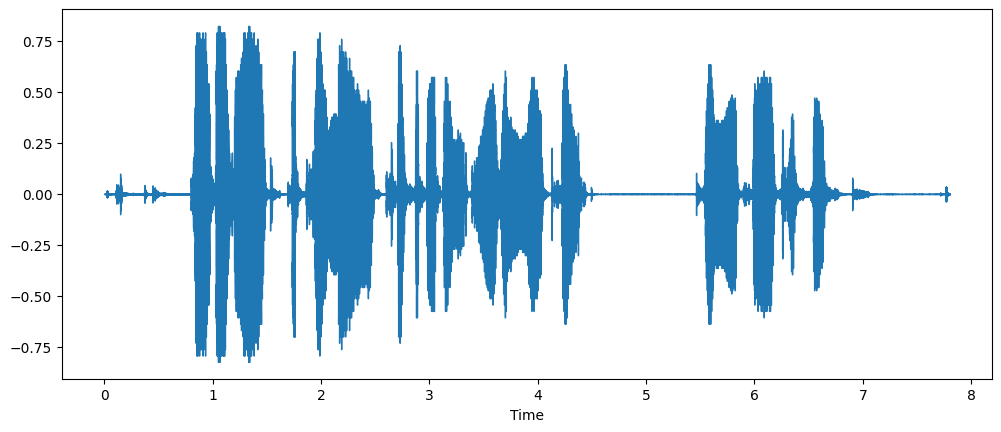

In [10]:
# Let’s plot the waveform for the first example
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

##Resampling audio data

In [21]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

##Filtering the dataset

In [12]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
  return input_length < MAX_DURATION_IN_SECONDS

In [13]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

##Pre-processing audio data

In [ ]:
# Let’s load the feature extractor from the pre-trained Whisper checkpoint
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [19]:
def prepare_dataset(example):
  audio = example["audio"]
  features = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"], padding=True)
  return features

In [22]:
# let's apply the data preparation function to all of our training examples
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 654
})

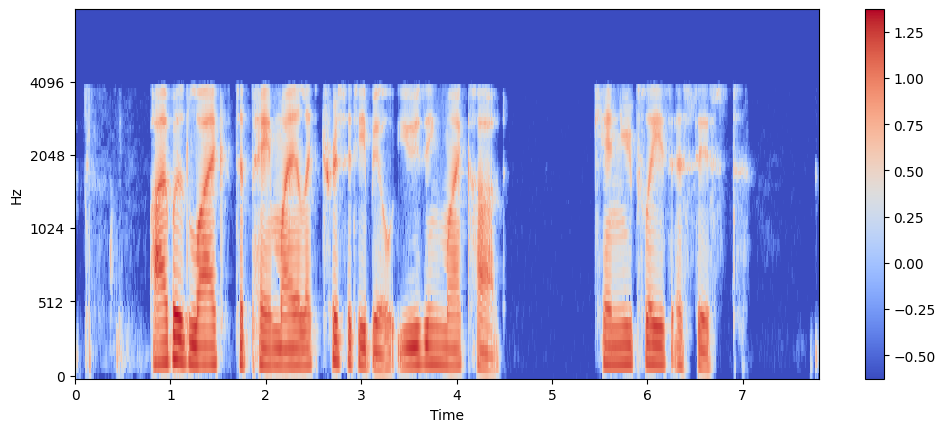

In [24]:
# let’s visualize it for one of the examples in the minds dataset
example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length
)
plt.colorbar()

In [ ]:
# let's make things even simpler
feature_processor = AutoProcessor.from_pretrained("openai/whisper-small")

In [27]:
def prepare_dataset(example):
  audio = example["audio"]
  features = feature_processor(audio["array"], sampling_rate=audio["sampling_rate"], padding=True)
  return features

In [28]:
# let's apply the data preparation function to all of our training examples
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 654
})

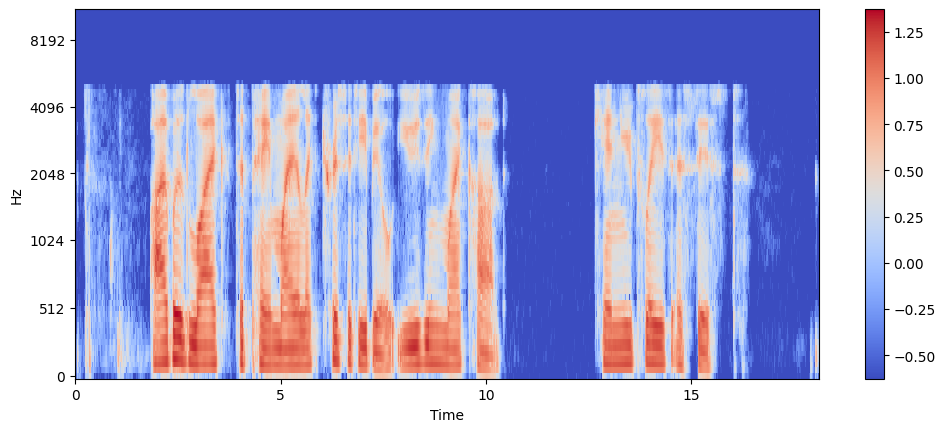

In [32]:
# let’s visualize it for one of the examples in the minds dataset
example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    #sr=feature_processor.sr,
    #hop_length=feature_processor.hop_length
)
plt.colorbar()